# DATASCI W261: Machine Learning at Scale

## Angela Gunn &  Jing Xu 
### angela@egunn.com  
### jaling@gmail.com

## MIDS - W261 - Section 3  
## February 17, 2016  
## Assignment : Week 5


----
## HW 5.0
**What is a data warehouse?** 

A data warehouse is a central repository of integrated data from one or many sources used for reporting and data analysis. In an enterprise setting, it serves as the primary repository of data from sales transactions to product inventories. Modern data warehouses can store:

* relational data
* semi-structured data like query logs
* unstructured data like tweets, titles of web pages

Data warehouses form a foundation for business intelligence and data science, and are leveraged to gain a competitive advantage in the marketplace through data mining.

**What is a Star schema? When is it used?**

A Star Schema is a type of data mart schema that consists of one or more fact tables referencing any number of dimension tables. It gets its name from the tendency of the physical model to resemble a star with the fact table in the center and dimension tables surrounding it.
<img src=starschema.png>
It is used to handle simpler queries as the join logic is usually simpler to handle than the join logic needed to retrieve data from a highly normalized transactional schemas. There is also more simplified business reporting logic, query performance gains, and faster aggregations compared to other schemas.

-----
## HW 5.1
**In the database world What is 3NF?**

3NF is third normal form, the third step in normalizing a database and builds on the first and second normal forms. It is a normalization process used to reduce the unnecessary duplication of data and making sure every value of of attribute column of a table exists as a value of another attribute column in the same or different table (referential integrity). This is done by ensuring that the data is in second normal form and that all the attributes in the table are determined only by the candidate keys of the table and not by any other non-prime attributes. 3NF is used to improve processing while minimizing storage costs, which is ideal for online transaction processing (OLTP) applications.

**Does machine learning use data in 3NF? If so why?**

3NF is often used for machine learning - 3NF's structure is ideal for machine processing. The removal of transitive functional dependency avoids inputting features for machine learning that are redundant and non-independent. Relational databases almost always contain structured, normalized data with indexes, and machine learning in this realm uses 3NF data inputs.

**In what form does ML consume data?**

Although 3NF works well for ML, ML consumes data in a variety of additional forms. Not all ML applications depend on data normalization - 1NF and 2NF can be fed into ML algorithms, although the effectiveness will vary depending on the algorithm and type of data being worked with. ML algorithms are now sophisticated enough to learn from unstructured data as well.

**Why would one use log files that are denormalized?**

Denormalized log files can be more efficient for queries that draw information from several tables that are stored on disk and require complex joins to complete, depending on the size and type of data. Denormalization is the process of attempting to optimize the read performance of a database by adding redundant data or by grouping data - it is a tradeoff of redundancy/extra space for scalability and read performance. Hadoop MapReduce for example primarily uses denormalized data that is fully contained in a single record to avoid costly joins.



-----
## HW 5.2
Using MRJob, implement a hashside join (memory-backed map-side) for left, 
right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

(1) Left joining Table Left with Table Right  
(2) Right joining Table Left with Table Right  
(3) Inner joining Table Left with Table Right  

### Approach:
1. Recognition of 2 tables: the LogData and the URL data.  

anonymous-msweb.data.pp: first 5 lines  
>V,1000,C,10001  
>V,1001,C,10001  
>V,1002,C,10001  
>V,1001,C,10002  
>V,1003,C,10002  

url.txt: first 2 lines  
>A,1287,1,"International AutoRoute","/autoroute"  
>A,1288,1,"library","/library

2. Using the URLs to be the left table, as it must be stored in memory and it is smaller

In [1]:
# Create a file with only URL(s), i.e. records starting with 'A'
!rm -v url.txt
!grep ^A anonymous-msweb.data > url.txt

removed ‘url.txt’


###Left Join:

In [1]:

%%writefile mrjob_leftjoin_hw52.py
#!/usr/bin/python
## mrjob_leftjoin_hw52.py
## Author: Angela Gunn & Jing Xu
## Description:Left Join
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value

import csv

def csv_readline(line):
    """Given a sting CSV line, return a list of strings."""
    for row in csv.reader([line]):
        return row


class leftjoin(MRJob):
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,
                     mapper=self.mapper, mapper_final = self.mapper_final)]
    
    def mapper_init(self):
        #store the URLs
        self.lefttable = {}
    
        with open('url.txt') as f:
            for line in f:
                cell = csv_readline(line)
                self.lefttable[cell[1]] = (cell[4],[]) #url, list of visitors
        
    def mapper(self, _, line):
        #this is the logs
        cell = csv_readline(line) 
        key = cell[1]
        self.lefttable[key][1].append(cell[3])
        
    def mapper_final(self):
        for key, values in self.lefttable.iteritems():
            url = values[0]
            if len(values[1]) > 0:
                for u in values[1]: yield key, (url, u)
            else:
                yield key, (url, "NONE")
                
        
if __name__ == '__main__':
    leftjoin.run()

Writing mrjob_leftjoin_hw52.py


In [2]:
# Running mrjob using a Hadoop Runner in local cluster
from mrjob_leftjoin_hw52 import leftjoin
import os

# Passing Hadoop Streaming parameters to:
# partition by leftmost part of composite key
# secodary sort by rightmost part of the same composite key

mr_job = leftjoin(args=['anonymous-msweb.data.pp', 
                        '--file', 'url.txt'])

output_file = "output_hw52_left.txt"
try:
    os.remove(output_file)
except OSError:
    pass

with mr_job.make_runner() as runner, open(output_file, 'a') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        #print mr_job.parse_output_line(line)
        f.write(str(line))

In [3]:
!echo "Number of results:"
!wc -l < output_hw52_left.txt
!echo "-----"
!echo "first 10 rows"
!echo "page_id [url, user]"
!head -10 output_hw52_left.txt

Number of results:
   98663
-----
first 10 rows
page_id [url, user]
"1142"	["/southafrica", "10372"]
"1142"	["/southafrica", "13352"]
"1142"	["/southafrica", "19019"]
"1142"	["/southafrica", "24124"]
"1142"	["/southafrica", "25638"]
"1142"	["/southafrica", "25798"]
"1142"	["/southafrica", "26342"]
"1142"	["/southafrica", "28044"]
"1142"	["/southafrica", "28821"]
"1142"	["/southafrica", "29837"]


###Right Join:

In [4]:

%%writefile mrjob_rightjoin_hw52.py
#!/usr/bin/python
## mrjob_rightjoin_hw52.py
## Author: Angela Gunn  & Jing Xu
## Description:right Join
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value

import csv

def csv_readline(line):
    """Given a sting CSV line, return a list of strings."""
    for row in csv.reader([line]):
        return row


class rightjoin(MRJob):
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,
                     mapper=self.mapper)]
    
    def mapper_init(self):
        #store the URLs
        self.lefttable = {}
        with open('url.txt') as f:
            for line in f:
                cell = csv_readline(line)
                self.lefttable[cell[1]] = cell[4]
        
    def mapper(self, _, line):
        #this is the logs
        cell = csv_readline(line) 
        if cell[1] in self.lefttable.keys():
            yield cell[1], (self.lefttable[cell[1]], cell[3]) #yield the matching rows.     
        else:
            yield None, (None , cell[3])
        
if __name__ == '__main__':
    rightjoin.run()

Writing mrjob_rightjoin_hw52.py


In [8]:
# Running mrjob using a Hadoop Runner in local cluster
from mrjob_rightjoin_hw52 import rightjoin
import os

# Passing Hadoop Streaming parameters to:
# partition by leftmost part of composite key
# secodary sort by rightmost part of the same composite key

mr_job = rightjoin(args=['anonymous-msweb.data.pp', 
                        '--file', 'url.txt'])

output_file = "output_hw52_right.txt"
try:
    os.remove(output_file)
except OSError:
    pass

with mr_job.make_runner() as runner, open(output_file, 'a') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        #print mr_job.parse_output_line(line)
        f.write(str(line))

In [9]:
!echo "Number of results:"
!wc -l < output_hw52_right.txt
!echo "-----"
!echo "first 10 rows"
!echo "page_id [url, user]"
!head -10 output_hw52_right.txt

Number of results:
   98654
-----
first 10 rows
page_id [url, user]
"1000"	["/regwiz", "10001"]
"1001"	["/support", "10001"]
"1002"	["/athome", "10001"]
"1001"	["/support", "10002"]
"1003"	["/kb", "10002"]
"1001"	["/support", "10003"]
"1003"	["/kb", "10003"]
"1004"	["/search", "10003"]
"1005"	["/norge", "10004"]
"1006"	["/misc", "10005"]


###Inner Join:

In [2]:

%%writefile mrjob_join_hw52.py
#!/usr/bin/python
## mrjob_join_hw52.py
## Author: Angela Gunn  & Jing Xu
## Description:Inner Join



from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value

import csv

def csv_readline(line):
    """Given a sting CSV line, return a list of strings."""
    for row in csv.reader([line]):
        return row

class innerjoin(MRJob):
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,
                     mapper=self.mapper)]
    
    def mapper_init(self):
        #store the URLs
        self.lefttable = {}
        with open('url.txt') as f:
            for line in f:
                cell = csv_readline(line)
                self.lefttable[cell[1]] = cell[4]
        
    def mapper(self, _, line):
        #this is the logs
        cell = csv_readline(line) 
        yield cell[1], (self.lefttable[cell[1]], cell[3]) #yield the matching rows.
        
        
if __name__ == '__main__':
    innerjoin.run()

Overwriting mrjob_join_hw52.py


In [3]:
# Running mrjob using a Hadoop Runner in local cluster
from mrjob_join_hw52 import innerjoin
import os

# Passing Hadoop Streaming parameters to:
# partition by leftmost part of composite key
# secodary sort by rightmost part of the same composite key

mr_job = innerjoin(args=['anonymous-msweb.data.pp', 
                        '--file', 'url.txt'])

output_file = "output_hw52_inner.txt"
try:
    os.remove(output_file)
except OSError:
    pass

with mr_job.make_runner() as runner, open(output_file, 'a') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        #print mr_job.parse_output_line(line)
        f.write(str(line))

In [4]:
!echo "Number of results:"
!wc -l < output_hw52_inner.txt
!echo "-----"
!echo "first 10 rows"
!echo "page_id [url, user]"
!head -10 output_hw52_inner.txt

Number of results:
98654
-----
first 10 rows
page_id [url, user]
"1000"	["/regwiz", "10001"]
"1001"	["/support", "10001"]
"1002"	["/athome", "10001"]
"1001"	["/support", "10002"]
"1003"	["/kb", "10002"]
"1001"	["/support", "10003"]
"1003"	["/kb", "10003"]
"1004"	["/search", "10003"]
"1005"	["/norge", "10004"]
"1006"	["/misc", "10005"]


---
##HW 5.3  EDA of Google n-grams dataset
A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox on s3:

   https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

   s3://filtered-5grams/

In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

For HW 5.3-5.5, for the Google n-grams dataset unit test and regression test your code using the 
first 10 lines of the following file:

    googlebooks-eng-all-5gram-20090715-0-filtered.txt

Once you are happy with your test results proceed to generating  your results on the Google n-grams dataset. 

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (please use the count information), i.e., unigrams
- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

####Response to Requirements
I tested these jobs locally on a small set from the googlebooks, as requested above. However, I did not realize that was to be part of our output for this question (wasn't there originally), so I do not have the outputs to show here.


###Longest 5-gram

In [11]:

%%writefile mrjob_longest_53.py
#!/usr/bin/python
## mrjob_longest_53.py
## Author: Angela Gunn  & Jing Xu
## Description:Find the longest 5-gram

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value

class longest_ngram(MRJob):
    long_ngram = None
    long_length = 0
    
    def steps(self):
        return [MRStep(mapper=self.mapper,
                         reducer=self.reducer,
                         reducer_final=self.reducer_final,
                       jobconf={
                            "mapred.map.tasks":4,
                            "mapred.reduce.tasks":1,
                            })]
        
    def mapper(self, _, line):
        #break out the lengths of the cells
        cell = line.split('\t')
        length = len(cell[0])
        yield cell[0], length

    def reducer(self, key, value):
        #Add to globals if biggest
        value = list(value)
        if sum(value) > self.long_length:
            self.long_ngram = key
            self.long_length = sum(value)
            
    def reducer_final(self):
        #output biggest
        yield self.long_ngram, self.long_length
        
if __name__ == '__main__':
    longest_ngram.run()

Overwriting mrjob_longest_53.py


In [1]:
!s3cmd rm --recursive s3://agunn-w261-hw5/longest53/
! python mrjob_longest_53.py -r emr s3://filtered-5grams \
    --output-dir=s3://agunn-w261-hw5/longest53 \
    --no-output \
    --no-strict-protocol

delete: 's3://agunn-w261-hw5/longest53/_SUCCESS'
delete: 's3://agunn-w261-hw5/longest53/part-00000'
Got unexpected keyword arguments: ssh_tunnel
using configs in /home/hduser/.mrjob.conf
creating new scratch bucket mrjob-3e5a84f2faf31709
using s3://mrjob-3e5a84f2faf31709/tmp/ as our scratch dir on S3
creating tmp directory /tmp/mrjob_longest_53.hduser.20160216.183744.356512
writing master bootstrap script to /tmp/mrjob_longest_53.hduser.20160216.183744.356512/b.py
creating S3 bucket 'mrjob-3e5a84f2faf31709' to use as scratch space
Copying non-input files into s3://mrjob-3e5a84f2faf31709/tmp/mrjob_longest_53.hduser.20160216.183744.356512/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-KMZT7NED7BMO
Created new job flow j-KMZT7NED7BMO
Job launched 31.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job on job flow j-KMZT7NED7BMO failed with sta

In [13]:
!s3cmd get s3://agunn-w261-hw5/longest53/part* HW5/longest53_out.txt
!head HW5/longest53_out.txt


ERROR: Parameter problem: File HW5/longest53_out.txt already exists. Use either of --force / --continue / --skip-existing or give it a new name.
"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"	159


###Top 10 Most Frequent

In [14]:

%%writefile mrjob_frequency_53.py
#!/usr/bin/python
## mrjob_frequency_53.py
## Author: Angela Gunn  & Jing Xu
## Description:Find the frequency of a word in the 5-gram

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value

import re

WORD_RE = re.compile(r"[A-Za-z0-9]+")

class frequency(MRJob):
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer,
                   jobconf={
                            "mapred.map.tasks":16,
                            "mapred.reduce.tasks":8,
                            }),
             MRStep(mapper=self.mapper_frequent_unigrams,
                   reducer=self.reducer_frequent_unigrams,
                   jobconf={
                            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                            'mapred.text.key.comparator.options': '-k1,1rn',
                            "mapred.map.tasks":4,
                            "mapred.reduce.tasks":1,
                            }
                   )
        ]
    
    def mapper(self, _, line):
        #get the word, and count for output
        line.strip()
        cell = re.split("\t",line)
        unigrams = cell[0].split()
        count = int(cell[1])
        for unigram in unigrams:
            yield unigram, count
    
    def combiner(self, unigram, counts):
        #combine counts
        yield unigram, sum(counts)
    
    def reducer(self, unigram, counts):
        #combine counts
        yield unigram, sum(counts)
        
    def mapper_frequent_unigrams(self, unigram, count):
        #Just passing along with count first so that they all get shuffled by the count
        yield count, unigram
        
    def reducer_frequent_unigrams(self, count, unigrams):
        #Printing.
        for unigram in unigrams:
            yield count, unigram
        
if __name__ == '__main__':
    frequency.run()

Overwriting mrjob_frequency_53.py


In [15]:
!s3cmd rm --recursive s3://agunn-w261-hw5/frequency53/
! python mrjob_frequency_53.py -r emr s3://filtered-5grams \
    --output-dir=s3://agunn-w261-hw5/frequency53 \
    --no-output \
    --no-strict-protocol

delete: 's3://agunn-w261-hw5/frequency53/_SUCCESS'
delete: 's3://agunn-w261-hw5/frequency53/part-00000'
Got unexpected keyword arguments: ssh_tunnel
using configs in /home/hduser/.mrjob.conf
creating new scratch bucket mrjob-dd1e164662921bff
using s3://mrjob-dd1e164662921bff/tmp/ as our scratch dir on S3
creating tmp directory /tmp/mrjob_frequency_53.hduser.20160216.093621.519523
writing master bootstrap script to /tmp/mrjob_frequency_53.hduser.20160216.093621.519523/b.py
creating S3 bucket 'mrjob-dd1e164662921bff' to use as scratch space
Copying non-input files into s3://mrjob-dd1e164662921bff/tmp/mrjob_frequency_53.hduser.20160216.093621.519523/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-14LX8WV79GC9C
Created new job flow j-14LX8WV79GC9C
Job launched 31.1s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.1s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 93.0s ago, status STA

In [16]:
!s3cmd get s3://agunn-w261-hw5/frequency53/part* HW5/frequency_out.txt
!head HW5/frequency_out.txt

ERROR: Parameter problem: File HW5/frequency_out.txt already exists. Use either of --force / --continue / --skip-existing or give it a new name.
5375699242	"the"
3691308874	"of"
2221164346	"to"
1387638591	"in"
1342195425	"a"
1135779433	"and"
798553959	"that"
756296656	"is"
688053106	"be"
481373389	"as"


###20 Most/Least Densely Words

In [17]:

%%writefile mrjob_density_53.py
#!/usr/bin/python
## mrjob_density_53.py
## Author: Angela Gunn  & Jing Xu
## Description:Find the density of the words in 5gram

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value

class density_53(MRJob):

    
    def steps(self):
        return [MRStep(mapper=self.mapper,
                         reducer=self.reducer, 
                   jobconf={
                    "mapred.map.tasks":16,
                    "mapred.reduce.tasks":8
                    }
                         ),
               MRStep(mapper=self.mapper_max_min,
                        reducer=self.reducer_max_min,
                   jobconf={
                            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                            'mapred.text.key.comparator.options': '-k1,1rn',
                            "mapred.map.tasks":4,
                            "mapred.reduce.tasks":1
                            }
                     )]
        
    def mapper(self, _, line):
        #output the density (count / pages)
        cell = line.split('\t')
        words = cell[0].split()
        density = round((int(cell[1]) * 1.0 / int(cell[2])), 3)
        for w in words:
            yield w.lower(), density
            
    def combiner(self, unigram, densities):
        #combine
        densities = [d for d in densities]
        yield unigram, min(densities) 
        yield unigram, max(densities)
        
    def reducer(self, unigram, densities):
        #combine
        densities = [d for d in densities]
        yield unigram, min(densities)
        yield unigram, max(densities)
        
    def mapper_max_min(self, unigram, density):
        #output with density first so grouping can happen
        yield density, unigram
        
    def reducer_max_min(self, density, unigrams):
        #final output
        for unigram in unigrams:
            yield density, unigram
            
        
if __name__ == '__main__':
    density_53.run()

Overwriting mrjob_density_53.py


In [18]:
!s3cmd rm --recursive s3://agunn-w261-hw5/density53/
! python mrjob_density_53.py -r emr s3://filtered-5grams \
    --output-dir=s3://agunn-w261-hw5/density53 \
    --no-output \
    --no-strict-protocol

delete: 's3://agunn-w261-hw5/density53/_SUCCESS'
delete: 's3://agunn-w261-hw5/density53/part-00000'
Got unexpected keyword arguments: ssh_tunnel
using configs in /home/hduser/.mrjob.conf
creating new scratch bucket mrjob-349aa6d211330c1d
using s3://mrjob-349aa6d211330c1d/tmp/ as our scratch dir on S3
creating tmp directory /tmp/mrjob_density_53.hduser.20160216.100149.962951
writing master bootstrap script to /tmp/mrjob_density_53.hduser.20160216.100149.962951/b.py
creating S3 bucket 'mrjob-349aa6d211330c1d' to use as scratch space
Copying non-input files into s3://mrjob-349aa6d211330c1d/tmp/mrjob_density_53.hduser.20160216.100149.962951/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-39IAQOO3X49KX
Created new job flow j-39IAQOO3X49KX
Job launched 31.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 93.2s ago, status STARTING: Pro

In [51]:
!rm HW5/density_out.txt
!s3cmd get s3://agunn-w261-hw5/density53/part* HW5/density_out.txt
!head -20  HW5/density_out.txt

download: 's3://agunn-w261-hw5/density53/part-00000' -> 'HW5/density_out.txt'  [1 of 1]
 9706995 of 9706995   100% in    1s     6.16 MB/s  done
29.704999999999998	"death"
14.912000000000001	"write"
14.912000000000001	"and"
12.380000000000001	"na"
11.557	"xxxx"
11.557	"xxxx"
10.882	"sc"
10.6	"beep"
10.022	"blah"
9.8040000000000003	"whole"
9.8040000000000003	"the"
9.7550000000000008	"that"
9.7550000000000008	"under"
9.7550000000000008	"demand"
9.5779999999999994	"may"
9.5779999999999994	"concurrent"
9.5779999999999994	"in"
9.5779999999999994	"result"
9.5779999999999994	"use"
9.4809999999999999	"expenditure"


###Distribution of 5-gram sizes (character length). 

In [1]:

%%writefile mrjob_distribution_53.py
#!/usr/bin/python
## mrjob_distribution_53.py
## Author: Angela Gunn  & Jing Xu
## Description: Distribution of 5gram lengths

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value

class distribution_53(MRJob):

    
    def steps(self):
        return [MRStep(mapper=self.mapper,
                       combiner = self.combiner,
                         reducer=self.reducer, 
                   jobconf={
                            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                            'mapred.text.key.comparator.options': '-k1,1rn',
                            "mapred.map.tasks":8,
                            "mapred.reduce.tasks":1
                            }
                     )]
        
    def mapper(self, _, line):
        #get length, and count = count
        cell = line.split('\t')
        ngram_length = len(cell[0])
        count = int(cell[1])
        yield ngram_length, count
            
    def combiner(self, length, count):
        #combine
        count = sum(count)
        yield length, count
        
    def reducer(self, length, count):
        #combine
        count = sum(count)
        yield length, count


        
if __name__ == '__main__':
    distribution_53.run()

Overwriting mrjob_distribution_53.py


In [2]:
!s3cmd rm --recursive s3://agunn-w261-hw5/distribution53/
! python mrjob_distribution_53.py -r emr s3://filtered-5grams \
    --output-dir=s3://agunn-w261-hw5/distribution53 \
    --no-output \
    --no-strict-protocol

delete: 's3://agunn-w261-hw5/distribution53/_SUCCESS'
delete: 's3://agunn-w261-hw5/distribution53/part-00000'
Got unexpected keyword arguments: ssh_tunnel
using configs in /home/hduser/.mrjob.conf
creating new scratch bucket mrjob-defa45cb0d5f744a
using s3://mrjob-defa45cb0d5f744a/tmp/ as our scratch dir on S3
creating tmp directory /tmp/mrjob_distribution_53.hduser.20160216.172543.656953
writing master bootstrap script to /tmp/mrjob_distribution_53.hduser.20160216.172543.656953/b.py
creating S3 bucket 'mrjob-defa45cb0d5f744a' to use as scratch space
Copying non-input files into s3://mrjob-defa45cb0d5f744a/tmp/mrjob_distribution_53.hduser.20160216.172543.656953/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-1LZKIY936I47I
Created new job flow j-1LZKIY936I47I
Job launched 31.1s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.1s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 93.0s 

In [7]:
!s3cmd get s3://agunn-w261-hw5/distribution53/part* HW5/distribution_out.txt
!echo "------------------------------"
!echo "ngram length   count of length"
!echo "------------------------------"
!head HW5/distribution_out.txt

ERROR: Parameter problem: File HW5/distribution_out.txt already exists. Use either of --force / --continue / --skip-existing or give it a new name.
------------------------------
ngram length   count of length
------------------------------
159	182
128	92
119	148
106	90
103	91
91	155
90	84
89	92
86	91
84	421


###Plot the data graphically using a histogram.

In [9]:
%matplotlib inline

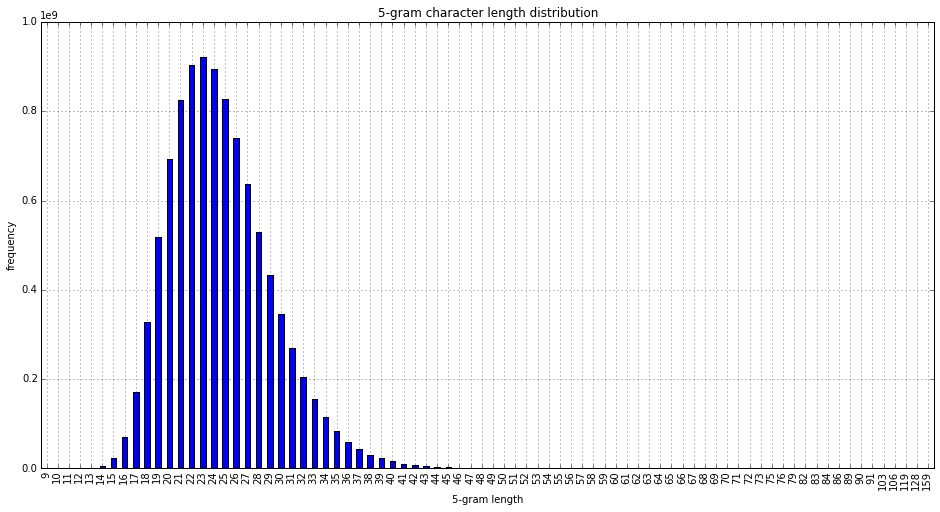

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 16, 8  # plotsize 

df = pd.read_csv('HW5/distribution_out.txt',sep='\t',header=None)
df.columns = ['length','frequency']
df = df.sort('length')
df = df.set_index('length')
my_plot = df.plot(kind='bar',legend=None,title="5-gram character length distribution")
my_plot.set_xlabel("5-gram length")
my_plot.set_ylabel("frequency")

-----
##HW 5.4  (over 2Gig of Data)



>For the remainder of this assignment you will work with two datasets:

>#### 1: unit/systems test data set: SYSTEMS TEST DATASET
>Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

>DocA {X:20, Y:30, Z:5}
>DocB {X:100, Y:20}
>DocC {M:5, N:20, Z:5}


>#### 2: A large subset of the Google n-grams dataset as was described above

>For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with you system.


In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

**(1) Build stripes of word co-ocurrence for the top 10,000 using the words ranked from 9001,-10,000 as a basis
most frequently appearing words across the entire set of 5-grams,
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).**

**(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.**

####==Design notes for (1)==
>For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

><*word,count>

>to ensure that the support arrives before the cooccurrences.

>In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

####==Design notes for (2)==
>For this task you will have to determine a method of comparison.
Here are a few that you might consider:

>- Jaccard
>- Cosine similarity
>- Spearman correlation
>- Euclidean distance
>- Taxicab (Manhattan) distance
>- Shortest path graph distance (a graph, because our data is symmetric!)
>- Pearson correlation
>- Kendall correlation
>...

>However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

*Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. *

####Preparing SYSTEMS_TEST_DATASET and SYSTEMS_TEST_DATASET_freq
Note: The frequency file was necessary because the frequency calculations from above expect a different input.  Being a small dataset, this was easy enough to do.

In [26]:
%%writefile createtest.py

with open('SYSTEMS_TEST_DATASET.txt','w') as f:
    f.write('DocA\t{"X":20,"Y":30,"Z":5}\n')
    f.write('DocB\t{"X":100,"Y":20}\n')
    f.write('DocC\t{"M":5,"N":20,"Z":5}\n')

with open('SYSTEMS_TEST_DATASET_freq.txt','w') as f:
    f.write('120\t"X"\n')
    f.write('150\t"Y"\n')
    f.write('10\t"Z"\n')
    f.write('5\t"M"\n')
    f.write('20\t"N"\n')

Overwriting createtest.py


In [27]:
!python createtest.py
!cat SYSTEMS_TEST_DATASET.txt
!cat SYSTEMS_TEST_DATASET_freq.txt

DocA	{"X":20,"Y":30,"Z":5}
DocB	{"X":100,"Y":20}
DocC	{"M":5,"N":20,"Z":5}
120	"X"
150	"Y"
10	"Z"
5	"M"
20	"N"


###5.4

**(1) Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 1001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).**



####==Design notes for (1)==
>For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

><*word,count>

>to ensure that the support arrives before the cooccurrences.

>In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

*Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. *

####Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

Cluster: 
    ec2_instance_type: m3.xlarge
    ec2_master_instance_type: m1.medium
    num_ec2_instances: 4

Index Construction: 
    1051.0s
    991 output stripes
    
Cosine:
    137.0s
    187434 lines out

Jaccard:
    196.0s
    187434 lines out

*The below is called bigram_occurrence, but really it is outputting the stripes for the inverse index*

In [4]:
%%writefile mrjob_bigram_occurrence.py
#!/usr/bin/python
## inverse_index.py
## Author: Angela Gunn & Jing Xu
## Description: Inverses an Index.


from mrjob.job import MRJob
from mrjob.step import MRStep
import csv
from sets import Set
import ast
import re


WORD_RE = re.compile(r"[A-Za-z0-9]+")


class bigram_occurrence(MRJob):
    
    doc_dict={} #global list
    
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,
                       mapper=self.mapper_main,
                     combiner=self.combiner,
                      reducer=self.reducer, 
                   jobconf={
                            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                            'mapred.text.key.comparator.options': '-k1,1',
                            "mapred.map.tasks":32,
                            "mapred.reduce.tasks":16
                            })]
    
    def mapper_init(self):
        #load unigrams
        self.unigrams = {}
        with open('topwords','r') as f:
            for line in f:
                cells = line.strip().split('\t')
                word = cells[1].replace('"','').strip()
                self.unigrams[word] = int(cells[0])
                yield "*"+word, int(cells[0])
                
                
    def mapper_main(self, _, line):        
        cell = line.strip().split('\t')
        words = WORD_RE.findall(cell[0])
        # Filter 5-grams to only those in list
        words = [w for w in words if w in self.unigrams.keys()]        
        w_len = len(words)
        for i in range(0, w_len): #for each word
            key = words[i]
            H = {}
            for j in xrange(0, w_len): #for each word after this
                w = words[j]
                self.increment_counter("mapper", "word_pairs", amount=1)
                if key != w: 
                    H[w] = H.get(w,0) + 1
                    self.increment_counter("mapper", "yield_pairs", amount=1)
            #emit 
            if len(H) > 0: yield key, H
                  
    
    def combiner(self, key, stripes):
        dic = {}
        key = key.replace('"','')
        if key[0] == '*':
            total = sum(stripes)
            yield key, total
        else:
            for s in stripes:
                for k, v in s.iteritems():
                    k = k.replace('"','')
                    dic[k] = dic.get(k,0) + int(v)
            yield key, dic

    def reducer(self, key, stripes):
        dic = {}
        key = key.replace('"','')
        if key[0] == '*':
            total = sum(stripes)
            yield key, total
        else:
            for s in stripes:
                for k, v in s.iteritems():
                    k = k.replace('"','')
                    dic[k] = dic.get(k,0) + int(v)
            self.increment_counter("reducer", "output_pairs", amount=1)
            yield key, dic
        

        
if __name__ == '__main__':
    bigram_occurrence.run()

Overwriting mrjob_bigram_occurrence.py


In [5]:
!s3cmd rm --recursive s3://agunn-w261-hw5/bigram54/
! python mrjob_bigram_occurrence.py -r emr s3://filtered-5grams \
    --file 's3://agunn-w261-hw5/topwords_touse9000.txt#topwords' \
    --output-dir=s3://agunn-w261-hw5/bigram54 \
    --no-output \
    --no-strict-protocol

delete: 's3://agunn-w261-hw5/bigram54/_SUCCESS'
delete: 's3://agunn-w261-hw5/bigram54/part-00000'
delete: 's3://agunn-w261-hw5/bigram54/part-00001'
delete: 's3://agunn-w261-hw5/bigram54/part-00002'
delete: 's3://agunn-w261-hw5/bigram54/part-00003'
delete: 's3://agunn-w261-hw5/bigram54/part-00004'
delete: 's3://agunn-w261-hw5/bigram54/part-00005'
delete: 's3://agunn-w261-hw5/bigram54/part-00006'
delete: 's3://agunn-w261-hw5/bigram54/part-00007'
delete: 's3://agunn-w261-hw5/bigram54/part-00008'
delete: 's3://agunn-w261-hw5/bigram54/part-00009'
delete: 's3://agunn-w261-hw5/bigram54/part-00010'
delete: 's3://agunn-w261-hw5/bigram54/part-00011'
delete: 's3://agunn-w261-hw5/bigram54/part-00012'
delete: 's3://agunn-w261-hw5/bigram54/part-00013'
delete: 's3://agunn-w261-hw5/bigram54/part-00014'
delete: 's3://agunn-w261-hw5/bigram54/part-00015'
Got unexpected keyword arguments: ssh_tunnel
using configs in /home/hduser/.mrjob.conf
creating new scratch bucket mrjob-002ecd56e2c2558d
using s3://mrj

In [6]:
!rm HW5/54_out.txt
!s3cmd get s3://agunn-w261-hw5/bigram54/part-00000 HW5/54_out.txt

!tail -1 HW5/54_out.txt

download: 's3://agunn-w261-hw5/bigram54/part-00000' -> 'HW5/54_out.txt'  [1 of 1]
download: 's3://agunn-w261-hw5/bigram54/part-00000' -> 'HW5/54_out.txt'  [1 of 1]
 16735 of 16735   100% in    0s    82.05 kB/s  done
"weaken"	{"vigor": 1, "critically": 1, "uterine": 1, "injure": 1, "diversion": 1, "abolish": 1, "reinforce": 4, "shrink": 1, "undermine": 2}



**(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.**

####==Design notes for (2)==
>For this task you will have to determine a method of comparison.
Here are a few that you might consider:

>- Jaccard
>- Cosine similarity
>- Spearman correlation
>- Euclidean distance
>- Taxicab (Manhattan) distance
>- Shortest path graph distance (a graph, because our data is symmetric!)
>- Pearson correlation
>- Kendall correlation
>...

>However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

*Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. *

####Rough Work
Mapper1:
  
     #   coming in with
        #   wordA {w1:#, w2:#, w3:#}
        #   coming in with
        #   wordB {w1:#, w2:#}
        #change to 
        #   wordA {w1:1, w2:1, w3:1}
        #   wordB {w1:1, w2:1}
        #get lengths
        #   LA = sqrt(1^2 + 1^2 + 1^2) = sqrt(3)
        #   LB = sqrt(1^2 + 1^2) = sqrt(2)
        #yield: 
        #   wordA {w1:1/LA}..., w2:1/LA, w3:1/LA}
        #   wordB {w1:1/LB, w2:1/LB}
    
Reducer1:
     #   coming in with:
        #    wordA [{w1:1/LA},{w2:1/LA}] 
        
Mapper2:
     #coming in with:
        #   wordA {w1:#, w2:#, w3:#}
        #yield:
        #   w1  {wordA:#}
        #   w2  {wordA:#}
        #   w3  {wordA:#}
        
Reducer2:
     #coming in with:
        #   w1  [{wordA:#},{wordB:#}]
        #   w2  [{wordA:#},{wordB:#}]
        #   w3  [{wordA:#}]
        #put each pair in global dic to calculate

In [7]:
%%writefile mrjob_Cosine_Inverted_Index.py
#!/usr/bin/python
## top_pages_43.py
## Author: Angela Gunn  & Jing Xu
## Description: Finds the top pages from the log


from mrjob.job import MRJob
from mrjob.step import MRStep
import csv
from sets import Set
import ast, json
import math



class Cosine_Inverted_Index(MRJob):

    global_doc_dict = {}
    def steps(self):
        return [
            MRStep(mapper=self.mapper, reducer= self.reducer,jobconf={
                    "mapred.map.tasks":16,
                    "mapred.reduce.tasks":8
                    }
                  ),
            MRStep(mapper=self.mapper2 ,combiner=self.combiner2, reducer=self.reducer2,
                   jobconf={
                    "mapred.map.tasks":8,
                    "mapred.reduce.tasks":4
                    }
                  )
               ]
    
    def mapper(self, _, line):
        #output doc   (key, count/sqrt)
        total_sqrt = 0
        total_sq_cnt= 0 
        key,terms = line.strip().split('\t')
        key = key.replace('"', '')
        if key[0] != '*':
            docs = eval(terms)
            #normalise the counts for cosine similarity
            for word, count in docs.iteritems():
                total_sq_cnt += count**2
            total_sqrt = math.sqrt(total_sq_cnt)
            for doc,count in docs.iteritems():
                yield doc,(key, 1.0*count/total_sqrt)
    
    def reducer(self,key,value):
        #output key, {doc:dist}
        doc_list ={}
        for doc,dist in value:
            doc_list[doc]=dist
        yield key, doc_list
        
    def mapper2(self,key,value):
        #output (word, word)  mutiplied key values
        keys = value.keys()
        for key1 in keys:
            for key2 in keys:
                if(key1 == key2):
                    continue
                multiplied_keys = value[key1]*value[key2]
                yield(key1,key2),multiplied_keys
    
    def combiner2(self,key,value):
        yield key,sum(value)
    
    def reducer2(self,key,value):
        self.increment_counter("reducer", "output_pairs", amount=1)
        yield key,sum(value)

        
if __name__ == '__main__':
    Cosine_Inverted_Index.run()

Overwriting mrjob_Cosine_Inverted_Index.py


####Test with SYSTEMS_TEST_DATASET

In [8]:
from mrjob_Cosine_Inverted_Index import Cosine_Inverted_Index
import os

#mr_job = Cosine_Inverted_Index(args=['HW5/54_out.txt'])
mr_job = Cosine_Inverted_Index(args=['SYSTEMS_TEST_DATASET.txt'])

output_file = "SYSTEMS_TEST_COSINE.out"
try:
    os.remove(output_file)
except OSError:
    pass

with mr_job.make_runner() as runner, open(output_file, 'a') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        #print mr_job.parse_output_line(line)
        f.write(str(line))


In [9]:
!cat SYSTEMS_TEST_COSINE.out

["DocA", "DocC"]	0.0323761954119088
["DocB", "DocA"]	0.7004041959724748
["DocC", "DocA"]	0.0323761954119088
["DocA", "DocB"]	0.7004041959724748


####Test with 5-grams

In [10]:
#code to make things public for future functions
!s3cmd setacl s3://agunn-w261-hw5/bigram54/* --acl-public --recursive

In [11]:
!s3cmd rm --recursive s3://agunn-w261-hw5/cosine54/
! python mrjob_Cosine_Inverted_Index.py -r emr s3://agunn-w261-hw5/bigram54/part* \
    --output-dir=s3://agunn-w261-hw5/cosine54 \
    --no-output \
    --no-strict-protocol

delete: 's3://agunn-w261-hw5/cosine54/_SUCCESS'
delete: 's3://agunn-w261-hw5/cosine54/part-00000'
delete: 's3://agunn-w261-hw5/cosine54/part-00001'
delete: 's3://agunn-w261-hw5/cosine54/part-00002'
delete: 's3://agunn-w261-hw5/cosine54/part-00003'
Got unexpected keyword arguments: ssh_tunnel
using configs in /home/hduser/.mrjob.conf
creating new scratch bucket mrjob-d2c0116cd8f7c1da
using s3://mrjob-d2c0116cd8f7c1da/tmp/ as our scratch dir on S3
creating tmp directory /tmp/mrjob_Cosine_Inverted_Index.hduser.20160217.082603.736169
writing master bootstrap script to /tmp/mrjob_Cosine_Inverted_Index.hduser.20160217.082603.736169/b.py
creating S3 bucket 'mrjob-d2c0116cd8f7c1da' to use as scratch space
Copying non-input files into s3://mrjob-d2c0116cd8f7c1da/tmp/mrjob_Cosine_Inverted_Index.hduser.20160217.082603.736169/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-1M4ELXM5IGXGU
Created new job flow j-1M4ELXM5IGXGU
Job launche

In [12]:
!rm  HW5/cosine54_out.txt
!s3cmd get s3://agunn-w261-hw5/cosine54/part-00000 HW5/cosine54_out.txt

!head HW5/cosine54_out.txt
!wc -l HW5/cosine54_out.txt

download: 's3://agunn-w261-hw5/cosine54/part-00000' -> 'HW5/cosine54_out.txt'  [1 of 1]
download: 's3://agunn-w261-hw5/cosine54/part-00000' -> 'HW5/cosine54_out.txt'  [1 of 1]
 2087595 of 2087595   100% in    0s     2.84 MB/s  done
["AB", "Archaeology"]	0.0048318200697723777
["AB", "Banking"]	0.00085993106191805887
["AB", "Brown"]	0.0010843072791358313
["AB", "Colleges"]	0.00015764451732376358
["AB", "Crime"]	0.0021306323807380781
["AB", "Electrical"]	0.0055941241338269753
["AB", "Excellency"]	0.0077924502102389211
["AB", "Female"]	0.0007356246980488243
["AB", "Fleet"]	0.00068170137651950345
["AB", "Gallery"]	0.00085036534653965836
46864 HW5/cosine54_out.txt


####Rough Work - Jaccard Index
Mapper1:
  
     #   coming in with
        #   wordA {w1:#, w2:#, w3:#}
        #   coming in with
        #   wordB {w1:#, w2:#}
        #change to 
        #   wordA {w1:1, w2:1, w3:1}
        #   wordB {w1:1, w2:1}
        #yield: 
        #   wordA (w1:1)..., (w2:1), (w3:1)
        #   wordB (w1:1), (w2:1)
    
Reducer1:
     #   coming in with:
        #    wordA [(w1:1),(w2:1)] 
        #yield
        #    wordA  w1
        #    wordA  w2
        
Mapper2:
     #coming in with:
        #   wordA {w1:#, w2:#, w3:#}
        #yield:
        #   (*,w1) 1
        #   (w1,w2) 1
        #   (w1,w3)  1
        
Reducer2:
     #yield:
        #   (w1,w2)  sum
        
Mapper3:
     #coming in with 
        #   (w1,w2)  count
     # if w1 == * then this is a count of the number of times this word occurrs |w2|
     # We will have all the counts - store in dic
     # calc = |xy| / (|x| + |y| - |xy|)
     # yield
       # (x,y) calc

In [13]:
%%writefile mrjob_Jaccard_Index.py
#!/usr/bin/python
## top_pages_43.py
## Author: Angela Gunn  & Jing Xu
## Description: Finds the top pages from the log


from mrjob.job import MRJob
from mrjob.step import MRStep
import csv
from sets import Set
import ast, json
import math


class Jaccard_Index(MRJob):
    global_doc_dict = {}
    def steps(self):
        return [
            MRStep(mapper=self.mapper , reducer= self.reducer, 
                   jobconf={
                    "mapred.map.tasks":16,
                    "mapred.reduce.tasks":8
                    }),
            MRStep(mapper=self.mapper2 ,combiner=self.combiner2, reducer=self.reducer2,
                   jobconf={
                    "mapred.map.tasks":8,
                    "mapred.reduce.tasks":4
                    }
                  ),
             MRStep(reducer=self.jaccard_cal, 
                    jobconf={
                    "mapred.map.tasks":4,
                    "mapred.reduce.tasks":1
                    })
            
               ]
    
    def mapper(self, _, line):
        key,terms = line.strip().split('\t')
        key = key.replace('"', '')
        if key[0] != '*':  #* represents a word with count - not a word with dictionary
            docs = eval(terms).keys()
            for doc in docs:
                yield doc,key
    
    def reducer(self,key,value):
        doc_list ={}
        for v in value:
            doc_list[v]=1
        yield key, doc_list.keys()
        
    def mapper2(self,key,value):
        doc_list = list(value)
        for key1 in doc_list:
            starkey = '*' + key1  #addint the * back... this seems redundant, but handled a strange error.
            yield (starkey, key1),1
            for key2 in doc_list:
                if(key1 != key2):
                    yield(key1,key2),1
    
    def combiner2(self,key,value):
        yield key,sum(value)
    
    def reducer2(self,key,value):
        yield key,sum(value)
    
    def jaccard_cal(self,key,value):
        docA,docB = key

        if docA.startswith('*'): #|doc|
            self.global_doc_dict[docB] = sum(value)
        else:  #at this point we have all the |doc|
            ab = sum(value)
            calc = 1.0*ab / (self.global_doc_dict[docA] + self.global_doc_dict[docB] - ab)
            
            self.increment_counter("reducer", "output_pairs", amount=1)
            yield (docA,docB), calc
        
if __name__ == '__main__':
    Jaccard_Index.run()

Overwriting mrjob_Jaccard_Index.py


####Test with SYSTEMS_TEST_DATASET

In [14]:
from mrjob_Jaccard_Index import Jaccard_Index
import os


mr_job = Jaccard_Index(args=['SYSTEMS_TEST_DATASET.txt'])

output_file = "SYSTEMS_TEST_JACCARD.out"
try:
    os.remove(output_file)
except OSError:
    pass

with mr_job.make_runner() as runner, open(output_file, 'a') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        #print mr_job.parse_output_line(line)
        f.write(str(line))


In [15]:
!head SYSTEMS_TEST_JACCARD.out
#!tail bigram54_Jaccard.out

["DocA", "DocB"]	0.6666666666666666
["DocA", "DocC"]	0.2
["DocB", "DocA"]	0.6666666666666666
["DocC", "DocA"]	0.2


####Test with 5-grams

In [16]:
!s3cmd rm --recursive s3://agunn-w261-hw5/jaccard54/
! python mrjob_Jaccard_Index.py -r emr s3://agunn-w261-hw5/bigram54/part* \
    --output-dir=s3://agunn-w261-hw5/jaccard54 \
    --no-output \
    --no-strict-protocol

delete: 's3://agunn-w261-hw5/jaccard54/_SUCCESS'
delete: 's3://agunn-w261-hw5/jaccard54/part-00000'
Got unexpected keyword arguments: ssh_tunnel
using configs in /home/hduser/.mrjob.conf
creating new scratch bucket mrjob-ba3ec136dc70d97b
using s3://mrjob-ba3ec136dc70d97b/tmp/ as our scratch dir on S3
creating tmp directory /tmp/mrjob_Jaccard_Index.hduser.20160217.083507.925889
writing master bootstrap script to /tmp/mrjob_Jaccard_Index.hduser.20160217.083507.925889/b.py
creating S3 bucket 'mrjob-ba3ec136dc70d97b' to use as scratch space
Copying non-input files into s3://mrjob-ba3ec136dc70d97b/tmp/mrjob_Jaccard_Index.hduser.20160217.083507.925889/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-39USKDJFLC9SZ
Created new job flow j-39USKDJFLC9SZ
Job launched 30.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 93.0s ago, status STAR

In [17]:
!rm HW5/jaccard54_out.txt
!s3cmd get s3://agunn-w261-hw5/jaccard54/part-00000 HW5/jaccard54_out.txt

!head HW5/jaccard54_out.txt
!wc -l HW5/jaccard54_out.txt

download: 's3://agunn-w261-hw5/jaccard54/part-00000' -> 'HW5/jaccard54_out.txt'  [1 of 1]
download: 's3://agunn-w261-hw5/jaccard54/part-00000' -> 'HW5/jaccard54_out.txt'  [1 of 1]
 8198304 of 8198304   100% in    1s     5.27 MB/s  done
["AB", "Address"]	0.038461538461538464
["AB", "Application"]	0.022727272727272728
["AB", "Archaeology"]	0.029411764705882353
["AB", "Banking"]	0.037037037037037035
["AB", "Biography"]	0.026315789473684209
["AB", "Biological"]	0.037037037037037035
["AB", "Brown"]	0.023255813953488372
["AB", "CD"]	0.040000000000000001
["AB", "Capital"]	0.022727272727272728
["AB", "Causes"]	0.02564102564102564
187434 HW5/jaccard54_out.txt


-----
##HW 5.5 Evaluation of synonyms that your discovered
In this part of the assignment you will evaluate the success of you synonym detector.
Take the top 1,000 closest/most similar/correlative pairs of words as determined
by your measure in (2), and use the synonyms function in the accompanying
python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.


####Implementation Notes
1. Sorted and truncated the jaccard and cosine output files to 10000 pairs
2. For each 10000 pairs, determined if in synonyms.
3. Assumed 1000 top pairs from 5.4 are predicted "hits" and the remaining are "misses"
4. Calculate statistics

In [25]:
!cat HW5/jaccard54_out.txt | sort -k3nr  > file_test_jaccard_55.out
!head -10000 file_test_jaccard_55.out > top10k_test_jaccard_55.out
!head top10k_test_jaccard_55.out
!wc -l top10k_test_jaccard_55.out

["soda", "sulphate"]	0.3888888888888889
["sulphate", "soda"]	0.3888888888888889
["insoluble", "solubility"]	0.375
["solubility", "insoluble"]	0.375
["cervix", "vagina"]	0.33333333333333331
["vagina", "cervix"]	0.33333333333333331
["alkaline", "solubility"]	0.31578947368421051
["solubility", "alkaline"]	0.31578947368421051
["embassy", "Embassy"]	0.30769230769230771
["Embassy", "embassy"]	0.30769230769230771
10000 top10k_test_jaccard_55.out


In [26]:
!cat HW5/cosine54_out.txt | sort -k3nr  > file_test_cosine_55.out
!head -10000 file_test_cosine_55.out > top10k_test_cosine_55.out
!head top10k_test_cosine_55.out
!wc -l top10k_test_cosine_55.out

["Eighth", "Fleet"]	0.96790553623374387
["morally", "sustainable"]	0.94175704074858269
["inquired", "availed"]	0.93525333208747397
["alveolar", "endothelial"]	0.89570818791440021
["endothelial", "alveolar"]	0.89570818791440021
["Published", "AT"]	0.8730833808181192
["frank", "concurrence"]	0.82832523327411578
["Mines", "Dominion"]	0.82311423512845294
["incarnation", "presiding"]	0.82305489175310154
["los", "pro"]	0.80366953875170655
10000 top10k_test_cosine_55.out


In [27]:
import nltk
from nltk.corpus import wordnet as wn
import sys
import ast
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()

def evaluate(file_name):

    line_cnt =0
    hits = []
    # Check if any of the top 10000 matches the synonym list
    with open(file_name, 'r') as f:
        for line in f:
            line_cnt += 1
            t = line.strip().split('\t') 
            words = t[0]
            words  = words.replace('"','').replace('[','').replace(']','')
            words =  words.split(',')
            w1 = words[0].lower().strip()
            w2 = words[1].lower().strip()
            
            if w1 in synonyms(w2) and w2 in synonyms(w1):
                hits.append(1)
            else:
                hits.append(0)
                
                
    #first 1000 rows we assume are "hits"
    predictions = [1]*1000 + [0]*(line_cnt-1000)
    
    # determine measures
    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    for i in range(len(predictions)):
        # true positives
        if hits[i] == 1 and predictions[i] == 1:
            true_positive += 1
        # true negatives
        elif hits[i] == 0 and predictions[i] == 0:
            true_negative += 1
        # false negatives
        elif hits[i] == 1 and predictions[i] == 0:
            false_negative += 1
        # false positives
        else:
            false_positive += 1    

    accuracy = float(true_positive + true_negative) / len(predictions)
    recall = float(true_positive) / float(true_positive + false_negative)
    precision = float(true_positive) / float(true_positive + false_positive)
    
    print "True Positive: {0}".format(true_positive)
    print "True Negative: {0}".format(true_negative)
    print "False Positive: {0}".format(false_positive)
    print "False Negative: {0}".format(false_negative)

    print "\n"
    print "Accuracy: {0}".format(accuracy)
    print "Precision: {0}".format(precision)
    print "Recall: {0}".format(recall)
    
    try:
        print "F1 Score: {0}".format(2 * (precision*recall) / (precision + recall))
    except ZeroDivisionError:
        print "F1 Score: Inf"
    
jaccard = 'top10k_test_jaccard_55.out'
cosine = 'top10k_test_cosine_55.out'

print "\n***** EVALUATE COSINE *****"
evaluate(cosine)
print "\n***** EVALUATE JACCARD *****"
evaluate(jaccard)


***** EVALUATE COSINE *****
True Positive: 1
True Negative: 8995
False Positive: 999
False Negative: 5


Accuracy: 0.8996
Precision: 0.001
Recall: 0.166666666667
F1 Score: 0.00198807157058

***** EVALUATE JACCARD *****
True Positive: 6
True Negative: 8990
False Positive: 994
False Negative: 10


Accuracy: 0.8996
Precision: 0.006
Recall: 0.375
F1 Score: 0.011811023622


----
##HW5.6 Optional

Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall


In [5]:
!cat HW5/frequency_out.txt | sed -n 9001,10000p > HW5/topwords_touse9000.txt
!cat HW5/frequency_out.txt | sed -n 8001,9000p > HW5/topwords_touse8000.txt
!cat HW5/frequency_out.txt | sed -n 7001,8000p > HW5/topwords_touse7000.txt
!cat HW5/frequency_out.txt | sed -n 6001,7000p > HW5/topwords_touse6000.txt
!cat HW5/frequency_out.txt | sed -n 5001,6000p > HW5/topwords_touse5000.txt
!cat HW5/frequency_out.txt | sed -n 4001,5000p > HW5/topwords_touse4000.txt
!cat HW5/frequency_out.txt | sed -n 3001,4000p > HW5/topwords_touse3000.txt
!cat HW5/frequency_out.txt | sed -n 2001,3000p > HW5/topwords_touse2000.txt
!cat HW5/frequency_out.txt | sed -n 1001,2000p > HW5/topwords_touse1000.txt
!head -1000 HW5/frequency_out.txt > HW5/topwords_touse0000.txt

In [6]:
#get top 1000 words.
#build stripes of co-occurrence on ALL 5-grams  word [co1, co2, co3]
#this will be output from mapper for each 
#!head HW5/topwords_touse.txt
#!wc -l HW5/topwords_touse.txt
!s3cmd put FILE HW5/topwords* s3://agunn-w261-hw5/

upload: 'HW5/topwords_touse.txt' -> 's3://agunn-w261-hw5/topwords_touse.txt'  [1 of 11]
 1766 of 1766   100% in    0s     7.71 kB/s  done
upload: 'HW5/topwords_touse.txt' -> 's3://agunn-w261-hw5/topwords_touse.txt'  [1 of 11]
 1766 of 1766   100% in    0s     7.62 kB/s  done
upload: 'HW5/topwords_touse0000.txt' -> 's3://agunn-w261-hw5/topwords_touse0000.txt'  [2 of 11]
 17173 of 17173   100% in    0s   125.78 kB/s  done
upload: 'HW5/topwords_touse1000.txt' -> 's3://agunn-w261-hw5/topwords_touse1000.txt'  [3 of 11]
 17815 of 17815   100% in    0s    87.65 kB/s  done
upload: 'HW5/topwords_touse2000.txt' -> 's3://agunn-w261-hw5/topwords_touse2000.txt'  [4 of 11]
 17934 of 17934   100% in    0s    84.75 kB/s  done
upload: 'HW5/topwords_touse3000.txt' -> 's3://agunn-w261-hw5/topwords_touse3000.txt'  [5 of 11]
 17510 of 17510   100% in    0s   159.39 kB/s  done
upload: 'HW5/topwords_touse4000.txt' -> 's3://agunn-w261-hw5/topwords_touse4000.txt'  [6 of 11]
 17222 of 17222   100% in    0s   14

###Written Response
**Cluster:**  
    ec2_instance_type: m3.xlarge  
    ec2_master_instance_type: m1.medium  
    num_ec2_instances: 4  
    

This shows clearly how Zipf's Law comes into play.  The top ranked words as far as frequency (0001-1000) took the longest to run. I also observed the words in the same top bracket occurred much more frequently with each other, which makes sense. Worst case in running this with 1000 words is all 1000 words appear with each other, meaning you have a full matrix, or O(n<sup>2</sup>)

I do not have the graphs requested for this question, just the table below. 

You may also see information about my results here: https://docs.google.com/presentation/d/1d26yGMnln55hZRYCrNdJKNCrjUIXj2r6LSq8scmBxoQ/edit?pref=2&pli=1#slide=id.g1196a69f19_1_5


|Bracket|Minutes|Pairs Compared in Mapper|
|----|----:|----:|
|9001-10000|17|1,477,162|
|8001-9000|17|1,826,865|
|7001-8000|17|2,839,147|
|6001-7000|17|2,842,799|
|5001-6000|17|3,639,018|
|4001-5000|17|5,042,215|
|3001-4000|18|7,386,679|
|2001-3000|18|11,955,068|
|1001-2000|19|23,684,259|
|0001-1000|155|923,892,455|




-----
##HW 5.7 (optional)
There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
>> stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

----
##HW 5.8 (optional)
There are many good ways to build our synonym detectors, so for optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer be interpretable as a network) inside of the 5-grams.

---

##Hw 5.9 (optional)
Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?
